In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')
from dataloader import BarrettsTissue
from torch.utils.data import DataLoader
from dataloader import get_wsi_paths
from torchvision.transforms import ToPILImage
import torch

In [2]:
TILE_SIZE = (512, 512)
TARGET_MPP = 2

In [16]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def patchify(imgs, p):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

def unpatchify(x, p):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]

    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

def show_masking(x, mask_ratio=0.75, patch_size=32):
    print('Masking ratio: {}, image size: {}x{}, patch size: {}'.format(mask_ratio, x.shape[2], x.shape[3], patch_size))
    patchified_batch = patchify(x, p=patch_size)
    x = torch.einsum('nchw->nhwc', x)

    # visualize the mask
    x_masked, mask, ids_restore = random_masking(patchified_batch, mask_ratio=mask_ratio)
    mask = mask.unsqueeze(-1).repeat(1, 1, patch_size**2 *3)                              # (N, H*W, p*p*3)
    mask = unpatchify(mask, p=patch_size)                                                                  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask)    
     
    # mask the image
    im_masked = x * (1 - mask)
    
    for img, mask in zip(x, im_masked):
        
        # make the plt figure larger
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 2, 1)
        show_image(img, "original")
        plt.subplot(1, 2, 2)
        show_image(mask, "masked")
        plt.tight_layout()
        plt.show()

In [3]:
# get paths to training files
tiff_files = get_wsi_paths('../split.yml', partition='training')[:10]

# create a datasets of Barrett's tissue patches
dataset = BarrettsTissue(tiff_files=tiff_files, tile_size=TILE_SIZE, target_mpp=TARGET_MPP)
print('Dataset consists of {} WSIs with {} tiles'.format(len(tiff_files), len(dataset)))
train_dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

Pre-loading WSIs...: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.43s/it]

Dataset consists of 10 WSIs with 239 tiles


torch.Size([4, 3, 512, 512])


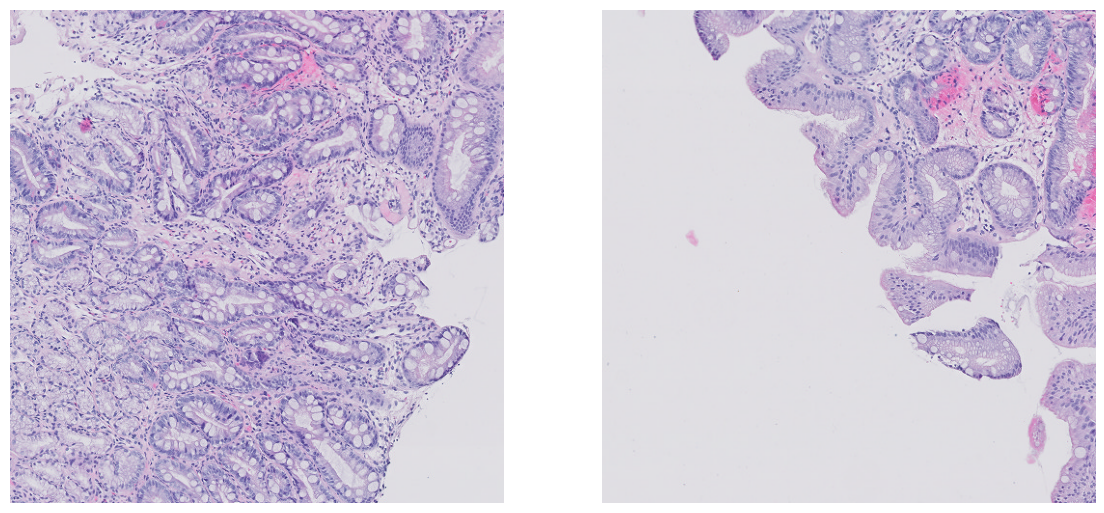

In [19]:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for tile_batch in train_dataloader:
    print(tile_batch.shape)
    plt.figure(figsize=(14, 14))
    for i, x in enumerate(tile_batch[:2]):
        plt.subplot(1,2, i + 1)
        image = ToPILImage()(x)
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    break

Masking ratio: 0.75, image size: 512x512, patch size: 32


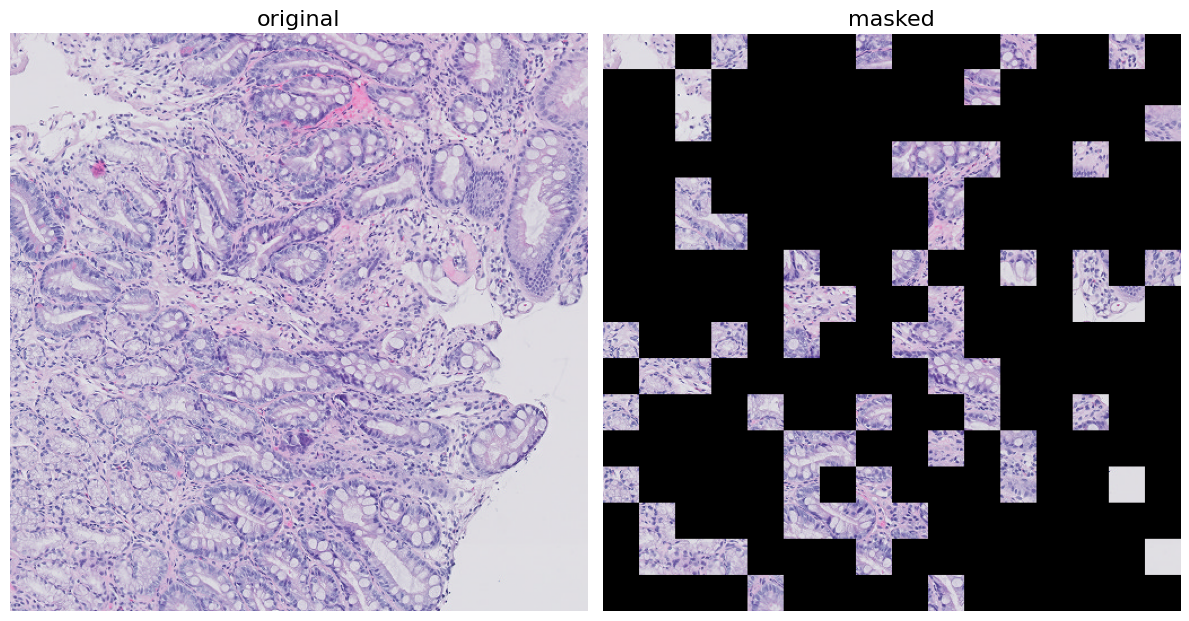

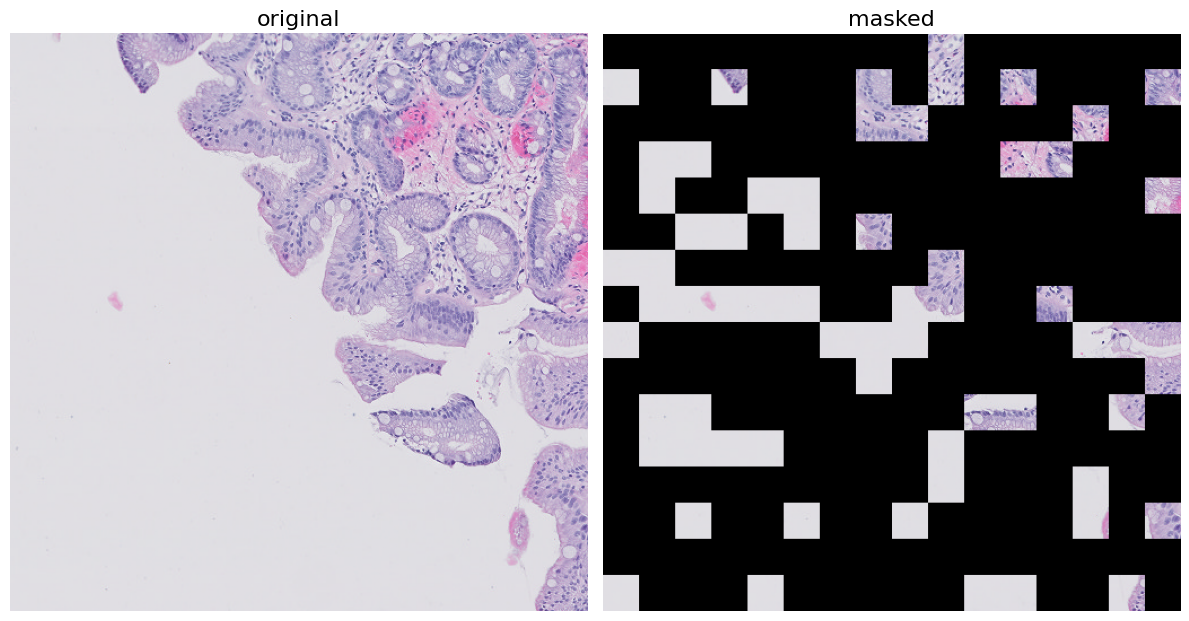

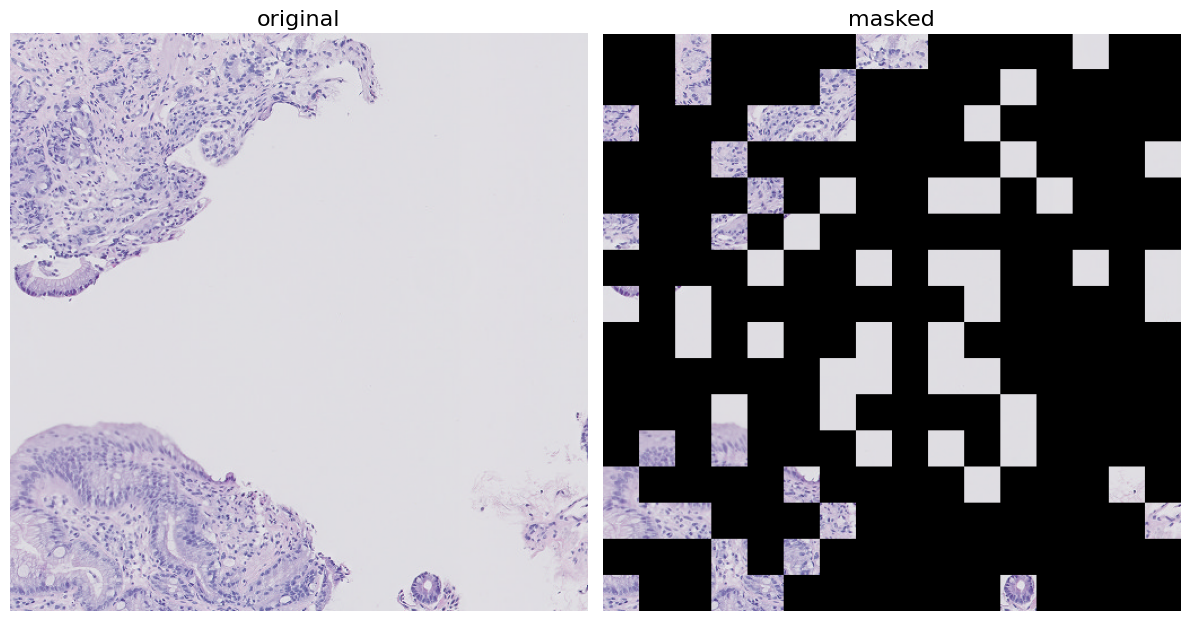

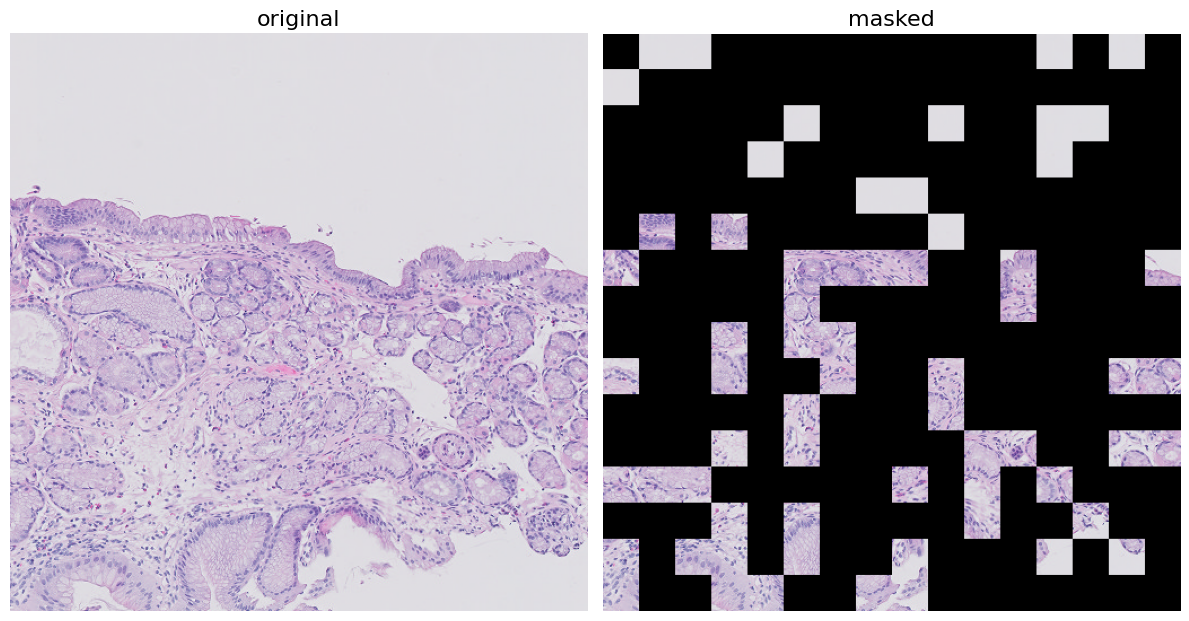

In [25]:
show_masking(tile_batch, mask_ratio=0.75, patch_size=32)